<a href="https://colab.research.google.com/github/Alx-Lebeau/Cours-EcoElec/blob/main/equilibre_court_terme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration Python

⚠️ à exécuter sans modifier le contenu ⚠️


In [30]:
!git clone https://github.com/Alx-Lebeau/Cours-EcoElec.git
%cd Cours-EcoElec/notebooks
!ls

import pandas as pd
import matplotlib.pyplot as plt
import pulp as pl


Cloning into 'Cours-EcoElec'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 382.11 KiB | 2.79 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/Cours-EcoElec/notebooks/Cours-EcoElec/notebooks
Consommation_France_2024.csv  Equilibre_Court_Terme.ipynb


# L'objectif de ce notebook est d'implémenter un équilibre de court terme du système électrique.

Le but de ce notebook est d'implémenter le problème de court terme, à savoir l'optimisation des programmes de production des différents moyens de production et de stockage (et éventuellement le délestage de consommation) dans l'objectif de minimiser le coût total pour la collectivité.

# Etape préliminaire : import de données de consommation

Avant de commencer à écrire le problème, nous allons importer des données de consommation. Il s'agit des séries horaires de consommation réalisée et de leur prévision faite la veille. La consommation est celle de la France en 2024.

Les données proviennent de la [plateforme Transparency](https://transparency.entsoe.eu/) de l'ENTSOE.

Après import, nous pouvons regarder l'allure annuelle de la consommation et son lien avec les évènements météorologiques (cf. [Bilan climatique de l'année 2024 en France (Météo France)](https://meteofrance.fr/actualite/presse/bilan-climatique-2024-en-france)).

Text(0, 0.5, 'MW')

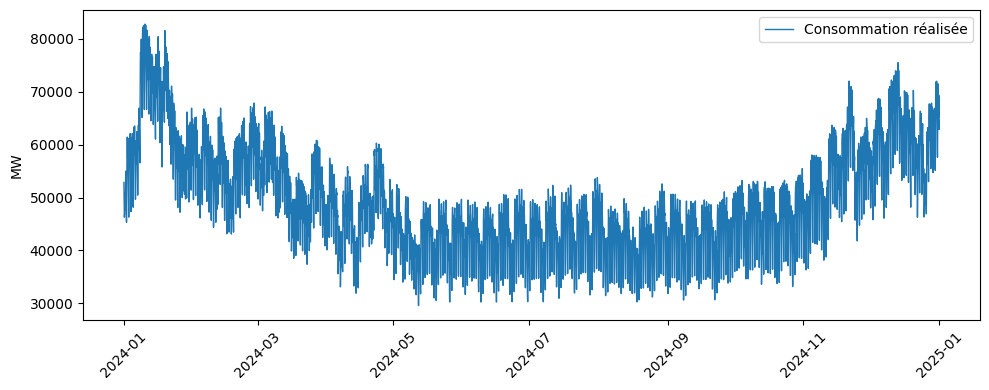

In [48]:

# Import des données
df = pd.read_csv("Consommation_France_2024.csv",index_col=0)
df["heure"] = pd.to_datetime(df["heure"])


# Visualisation de l'évolution annuelle de la consommation réalisée

fig, ax = plt.subplots(tight_layout=True,figsize =(10,4))

ax.plot(df["heure"],df["Consommation réalisée (MW)"],lw=1,label="Consommation réalisée")
ax.legend(loc="best")
ax.tick_params(axis="x", labelrotation=45)
ax.set_ylabel("MW")


Pour la suite, nous allons sélectionner une semaine pour réduire la taille du problème.

Au passage, nous pouvons mieux voir les variations régulières de la consommation à l'échelle de la semaine, notamment les cycles jour/nuit, les creux d'après midi, la différence jours ouvrés/week-end.


👉 N'hésitez pas à changer `heure_debut` et `heure_fin` pour visualiser différentes semaine.

Text(0, 0.5, 'MW')

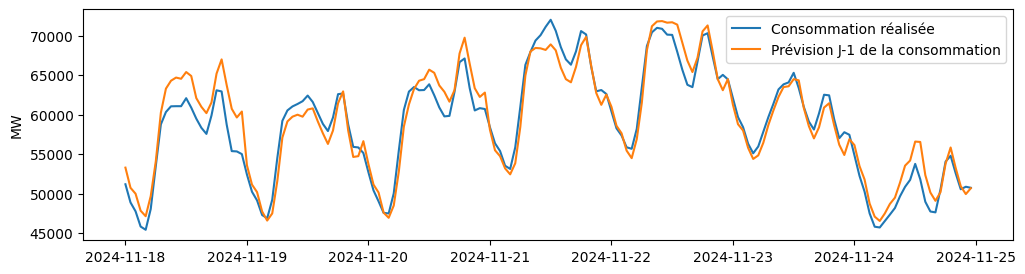

In [44]:
# Sélection de la semaine

heure_debut = "2024-11-18 00:00:00"
heure_fin = "2024-11-24 23:00:00"

semaine_example = df[df["heure"].between(heure_debut, heure_fin)]

# Traçage du graphique

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(semaine_example["heure"],
        semaine_example["Consommation réalisée (MW)"],
        label="Consommation réalisée")

ax.plot(semaine_example["heure"],
        semaine_example["Prévision J-1 de la consommation (MW)"],
        label = "Prévision J-1 de la consommation")

ax.legend(loc="best")
ax.set_ylabel("MW")

# Premier modèle

## Données d'entrée

In [38]:


# ---- Données d'entrée ----
# Générateurs : coût variable et capacité maximale (MW)
generateurs = {
    "nucléaire": {"cout_var": 10.0, "capacite": 50000.0},
    "hydraulique":     {"cout_var": 50.0, "capacite": 5000.0},
    "gaz":   {"cout_var": 100.0, "capacite": 10000.0},
}

# Demande (MW) à chaque pas de temps

demande = semaine_example["Consommation réalisée (MW)"].values


## Ecriture du modèle
### Initialisation

In [39]:
# ---- Ensembles ----
techs = list(generateurs.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)



### Définition des variables décision

In [40]:
# ---- Variables de décision ----
# prod[g, t] = production de la technologie g au temps t (MW)
prod = pl.LpVariable.dicts("prod", (techs, T), lowBound=0)



### Définition de l'objectif

In [41]:
# ---- Objectif : minimiser le coût total ----
modele += pl.lpSum(
    prod[g][t] * generateurs[g]["cout_var"]
    for g in techs for t in T
)



### Définition des contrainte

In [42]:
# ---- Contraintes ----

# 1) Équilibre offre = demande à chaque pas de temps
for t in T:
    modele += pl.lpSum(prod[g][t] for g in techs) == demande[t], f"Equilibre_t{t}"

# 2) Limite de capacité de chaque centrale
for g in techs:
    cap = generateurs[g]["capacite"]
    for t in T:
        modele += prod[g][t] <= cap, f"Capacite_{g}_t{t}"



### Résolution et affichage des résultats

In [43]:
# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))

# ---- Affichage des résultats ----
for g in techs:
    print(f"\nProduction de {g} :")
    for t in T:
        print(f"  t={t} : {prod[g][t].value():6.2f} MW")


Statut : Infeasible
Coût total : 192358610.0

Production de nucléaire :
  t=0 : 51195.00 MW
  t=1 : 48894.00 MW
  t=2 : 47772.00 MW
  t=3 : 45842.00 MW
  t=4 : 45433.00 MW
  t=5 : 48067.00 MW
  t=6 : 53510.00 MW
  t=7 : 50000.00 MW
  t=8 : 50000.00 MW
  t=9 : 50000.00 MW
  t=10 : 50000.00 MW
  t=11 : 50000.00 MW
  t=12 : 50000.00 MW
  t=13 : 50000.00 MW
  t=14 : 50000.00 MW
  t=15 : 50000.00 MW
  t=16 : 50000.00 MW
  t=17 : 50000.00 MW
  t=18 : 50000.00 MW
  t=19 : 50000.00 MW
  t=20 : 50000.00 MW
  t=21 : 50000.00 MW
  t=22 : 50000.00 MW
  t=23 : 50000.00 MW
  t=24 : 52431.00 MW
  t=25 : 50247.00 MW
  t=26 : 49150.00 MW
  t=27 : 47305.00 MW
  t=28 : 46882.00 MW
  t=29 : 49239.00 MW
  t=30 : 54511.00 MW
  t=31 : 50000.00 MW
  t=32 : 50000.00 MW
  t=33 : 50000.00 MW
  t=34 : 50000.00 MW
  t=35 : 50000.00 MW
  t=36 : 50000.00 MW
  t=37 : 50000.00 MW
  t=38 : 50000.00 MW
  t=39 : 50000.00 MW
  t=40 : 50000.00 MW
  t=41 : 50000.00 MW
  t=42 : 50000.00 MW
  t=43 : 50000.00 MW
  t=44 : 50000